In [54]:
import os
import numpy as np
import pandas as pd
import cv2
import json
from scipy.io import loadmat 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
# --- Configurações de Caminho para MPIIGaze ---
CAMINHO_BASE = '..'
MPIIGAZE_PATH = os.path.join(CAMINHO_BASE, 'mpiigaze_real', 'MPIIGaze', 'Data', 'Normalized')
output_dir_sequences = 'processed_sequences_mpiigaze'
MODELO_SALVO = os.path.join(CAMINHO_BASE, 'models', 'mpiigaze_attention_model.keras')

# Verificação dos caminhos
print(f"MPIIGAZE_PATH: {MPIIGAZE_PATH} - Existe? {os.path.exists(MPIIGAZE_PATH)}")
print(f"output_dir_sequences: {output_dir_sequences} - Existe? {os.path.exists(output_dir_sequences)}")

if not os.path.exists(MPIIGAZE_PATH):
    raise FileNotFoundError(f'MPIIGaze não encontrado em: {MPIIGAZE_PATH}')

IMG_SIZE = (64, 64)
TIME_WINDOW = 10

MPIIGAZE_PATH: ../mpiigaze_real/MPIIGaze/Data/Normalized - Existe? True
output_dir_sequences: processed_sequences_mpiigaze - Existe? False


In [56]:
# --- 1. Processar dados MPIIGaze ---
print("Processando dados MPIIGaze...")

def convert_gaze_to_attention(pitch, yaw, threshold_degrees=15):
    """Converte coordenadas de gaze em classificação de atenção"""
    total_angle = np.sqrt(pitch**2 + yaw**2) * 180 / np.pi
    return 1 if total_angle <= threshold_degrees else 0

all_images = []
all_labels = []
processed_files = 0
target_files = 50  # Começar com poucos arquivos para teste

print("Carregando arquivos .mat do MPIIGaze...")

# Percorrer diretórios de participantes
for participant_dir in sorted(os.listdir(MPIIGAZE_PATH)):
    if processed_files >= target_files:
        break
        
    participant_path = os.path.join(MPIIGAZE_PATH, participant_dir)
    if not os.path.isdir(participant_path):
        continue
        
    print(f"Processando participante: {participant_dir}")
    
    for day_file in sorted(os.listdir(participant_path)):
        if processed_files >= target_files:
            break
            
        if not day_file.endswith('.mat'):
            continue
            
        mat_path = os.path.join(participant_path, day_file)
        
        try:
            # Carregar arquivo .mat
            mat_data = loadmat(mat_path)
            data = mat_data['data'][0, 0]
            
            # Processar olho direito
            eye_data = data['right'][0, 0]
            images = eye_data['image']
            gazes = eye_data['gaze']
            
            for img, gaze in zip(images, gazes):
                # Preprocessar imagem
                img_resized = cv2.resize(img, IMG_SIZE)
                if len(img_resized.shape) == 2:  # Grayscale para RGB
                    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
                img_normalized = img_resized.astype('float32') / 255.0
                
                # Converter gaze para atenção
                pitch, yaw = gaze[0], gaze[1]
                attention_label = convert_gaze_to_attention(pitch, yaw)
                
                all_images.append(img_normalized)
                all_labels.append(attention_label)
            
            processed_files += 1
            if processed_files % 10 == 0:
                print(f"Processados {processed_files} arquivos...")
                
        except Exception as e:
            print(f"Erro ao processar {mat_path}: {e}")
            continue

images_array = np.array(all_images)
labels_array = np.array(all_labels)

print(f"\nProcessamento concluído:")
print(f"  Total de imagens: {len(images_array)}")

# Verificar distribuição
unique_labels, counts = np.unique(labels_array, return_counts=True)
distribution = dict(zip(unique_labels, counts))
print(f"  Distribuição: {distribution}")

for label, count in distribution.items():
    percentage = (count / len(labels_array)) * 100
    print(f"    Classe {label}: {count} amostras ({percentage:.1f}%)")

if len(images_array) == 0:
    print("Nenhuma imagem foi processada. Verifique o MPIIGaze.")
    exit()

Processando dados MPIIGaze...
Carregando arquivos .mat do MPIIGaze...
Processando participante: p00
Processados 10 arquivos...
Processados 20 arquivos...
Processados 30 arquivos...
Processando participante: p01
Processados 40 arquivos...
Processados 50 arquivos...

Processamento concluído:
  Total de imagens: 33445
  Distribuição: {np.int64(0): np.int64(7234), np.int64(1): np.int64(26211)}
    Classe 0: 7234 amostras (21.6%)
    Classe 1: 26211 amostras (78.4%)


In [72]:
import shutil
if os.path.exists(output_dir_sequences):
    shutil.rmtree(output_dir_sequences)
    print("Lotes antigos removidos.")

# --- 3. Agrupar em sequências e salvar em lotes ---
print("Criando sequências de dados em lotes...")

# Define o tamanho do lote para a criação das sequências.
BATCH_SIZE_SEQUENCE = 2000

# SEMPRE processar (removida a verificação que pulava o processamento)
if not os.path.exists(output_dir_sequences):
    os.makedirs(output_dir_sequences)

# Armazena os dados do lote atual
current_batch_data = []
current_batch_labels = []
batch_counter = 0

print("IMPORTANTE: Usando janelas não-sobrepostas para evitar data leakage.")

# CORREÇÃO PRINCIPAL: Usar step=TIME_WINDOW para evitar sobreposição
total_possible_sequences = (len(images_array) - TIME_WINDOW + 1)
non_overlapping_sequences = len(images_array) // TIME_WINDOW

print(f"Sequências possíveis com sobreposição: {total_possible_sequences}")
print(f"Sequências sem sobreposição: {non_overlapping_sequences}")

sequence_count = 0

# Mudança crítica: step=TIME_WINDOW em vez de step=1
for i in range(0, len(images_array) - TIME_WINDOW + 1, TIME_WINDOW):
    if i + TIME_WINDOW <= len(images_array):
        sequence_images = images_array[i:i + TIME_WINDOW]
        window_labels = labels_array[i:i + TIME_WINDOW]
        
        # Verificar se a janela tem rótulos válidos
        if len(window_labels) == TIME_WINDOW:
            sequence_label = 1 if np.mean(window_labels) > 0.9 else 0
            
            current_batch_data.append(sequence_images)
            current_batch_labels.append(sequence_label)
            sequence_count += 1
            
            if sequence_count % 500 == 0:
                print(f"Criadas {sequence_count} sequências...")

    # Quando o lote atual atingir o tamanho definido, salve-o
    if len(current_batch_data) == BATCH_SIZE_SEQUENCE or i >= len(images_array) - TIME_WINDOW:
        if len(current_batch_data) > 0:  # Só salva se tiver dados
            print(f"Salvando lote {batch_counter} com {len(current_batch_data)} amostras.")
            
            X_batch = np.array(current_batch_data)
            y_batch = np.array(current_batch_labels)
            
            # Verificar distribuição do lote atual
            unique_batch, counts_batch = np.unique(y_batch, return_counts=True)
            print(f"  Distribuição do lote {batch_counter}: {dict(zip(unique_batch, counts_batch))}")
            
            # Salve os arrays em arquivos .npy
            np.save(os.path.join(output_dir_sequences, f'X_batch_{batch_counter}.npy'), X_batch)
            np.save(os.path.join(output_dir_sequences, f'y_batch_{batch_counter}.npy'), y_batch)
            
            # Limpe a memória para o próximo lote
            current_batch_data = []
            current_batch_labels = []
            batch_counter += 1

print(f"Processamento em lotes concluído. {batch_counter} lotes criados.")
print(f"Total de sequências criadas: {sequence_count}")

# Verificar distribuição geral das sequências
if batch_counter > 0:
    all_sequence_labels = []
    for b in range(batch_counter):
        y_batch = np.load(os.path.join(output_dir_sequences, f'y_batch_{b}.npy'))
        all_sequence_labels.extend(y_batch)
    
    unique_seq, counts_seq = np.unique(all_sequence_labels, return_counts=True)
    print(f"Distribuição final das sequências: {dict(zip(unique_seq, counts_seq))}")

Lotes antigos removidos.
Criando sequências de dados em lotes...
IMPORTANTE: Usando janelas não-sobrepostas para evitar data leakage.
Sequências possíveis com sobreposição: 33436
Sequências sem sobreposição: 3344
Criadas 500 sequências...
Criadas 1000 sequências...
Criadas 1500 sequências...
Criadas 2000 sequências...
Salvando lote 0 com 2000 amostras.
  Distribuição do lote 0: {np.int64(0): np.int64(1782), np.int64(1): np.int64(218)}
Criadas 2500 sequências...
Criadas 3000 sequências...
Processamento em lotes concluído. 1 lotes criados.
Total de sequências criadas: 3344
Distribuição final das sequências: {np.int64(0): np.int64(1782), np.int64(1): np.int64(218)}


In [73]:
# Carregar a lista de todos os arquivos de lote
batch_files = sorted([f for f in os.listdir(output_dir_sequences) if f.startswith('X_batch_')])
total_batches = len(batch_files)

print(f"Arquivos de lote encontrados: {batch_files}")

# Verificar se existem lotes suficientes para divisão
if total_batches < 3:
    print(f"AVISO: Apenas {total_batches} lotes encontrados. Isso pode não ser suficiente para uma divisão adequada.")
    if total_batches == 1:
        print("Com apenas 1 lote, todo o dataset será usado para treino.")
        train_batches_indices = np.array([0])
        val_batches_indices = np.array([])
        test_batches_indices = np.array([])
    elif total_batches == 2:
        print("Com apenas 2 lotes, usando 1 para treino e 1 para validação.")
        train_batches_indices = np.array([0])
        val_batches_indices = np.array([1])
        test_batches_indices = np.array([])
else:
    # Crie uma lista de índices para cada lote
    batch_indices = np.arange(total_batches)
    
    # Divida os índices dos lotes em treino, validação e teste
    train_batches_indices, temp_batches_indices = train_test_split(
        batch_indices, test_size=0.3, random_state=42
    )
    val_batches_indices, test_batches_indices = train_test_split(
        temp_batches_indices, test_size=0.5, random_state=42
    )

print(f"Total de lotes: {total_batches}")
print(f"Lotes para treino: {len(train_batches_indices)} ({train_batches_indices})")
print(f"Lotes para validação: {len(val_batches_indices)} ({val_batches_indices})")
print(f"Lotes para teste: {len(test_batches_indices)} ({test_batches_indices})")

# Verificar a distribuição dos dados em cada conjunto
def check_data_distribution(batch_indices_list, set_name):
    if len(batch_indices_list) == 0:
        print(f"{set_name}: Vazio")
        return
    
    total_samples = 0
    all_labels = []
    
    for idx in batch_indices_list:
        y_batch = np.load(os.path.join(output_dir_sequences, f'y_batch_{idx}.npy'))
        total_samples += len(y_batch)
        all_labels.extend(y_batch)
    
    if len(all_labels) > 0:
        unique_labels, counts = np.unique(all_labels, return_counts=True)
        distribution = dict(zip(unique_labels, counts))
        percentages = {k: f"{(v/total_samples)*100:.1f}%" for k, v in distribution.items()}
        
        print(f"{set_name}: {total_samples} amostras")
        print(f"  Distribuição: {distribution}")
        print(f"  Percentuais: {percentages}")
    else:
        print(f"{set_name}: Sem dados")

print("\n--- Distribuição dos dados por conjunto ---")
check_data_distribution(train_batches_indices, "TREINO")
check_data_distribution(val_batches_indices, "VALIDAÇÃO")
check_data_distribution(test_batches_indices, "TESTE")

Arquivos de lote encontrados: ['X_batch_0.npy']
AVISO: Apenas 1 lotes encontrados. Isso pode não ser suficiente para uma divisão adequada.
Com apenas 1 lote, todo o dataset será usado para treino.
Total de lotes: 1
Lotes para treino: 1 ([0])
Lotes para validação: 0 ([])
Lotes para teste: 0 ([])

--- Distribuição dos dados por conjunto ---
TREINO: 2000 amostras
  Distribuição: {np.int64(0): np.int64(1782), np.int64(1): np.int64(218)}
  Percentuais: {np.int64(0): '89.1%', np.int64(1): '10.9%'}
VALIDAÇÃO: Vazio
TESTE: Vazio


In [74]:
# --- 4. Gerador de Dados para o Treinamento (Otimizado) ---
def data_generator_optimized(batch_indices_to_use, batch_size):
    """
    Função geradora para carregar dados em mini-lotes para o treinamento.
    """
    while True:
        # Embaralha os índices dos lotes .npy a cada época
        np.random.shuffle(batch_indices_to_use)
        
        for i in batch_indices_to_use:
            # Carrega um lote completo da memória (X_batch, y_batch)
            X_batch = np.load(os.path.join(output_dir_sequences, f'X_batch_{i}.npy'))
            y_batch = np.load(os.path.join(output_dir_sequences, f'y_batch_{i}.npy'))
            
            # Embaralha os dados dentro do lote para evitar dependência de ordem
            indices_in_batch = np.arange(len(X_batch))
            np.random.shuffle(indices_in_batch)
            
            # Divida o lote em mini-lotes para o treinamento
            for start in range(0, len(X_batch), batch_size):
                end = start + batch_size
                X_mini_batch = X_batch[indices_in_batch[start:end]]
                y_mini_batch = y_batch[indices_in_batch[start:end]]
                
                # Use o 'yield' para entregar os mini-lotes para o modelo
                yield X_mini_batch, y_mini_batch


In [75]:
# --- 5. Construir o modelo CNN-LSTM ---
print("\nConstruindo o modelo CNN-LSTM...")

from tensorflow.keras.layers import Dropout

X_sample = np.load(os.path.join(output_dir_sequences, f'X_batch_{train_batches_indices[0]}.npy'))
input_shape = X_sample.shape[1:]

print(f"Input shape: {input_shape}")
print(f"Amostra do batch: {X_sample.shape}")

model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.25)),  
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.25)),
    TimeDistributed(Flatten()),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

print("Modelo construído com sucesso!")


Construindo o modelo CNN-LSTM...
Input shape: (10, 64, 64, 3)
Amostra do batch: (2000, 10, 64, 64, 3)
Modelo construído com sucesso!


In [76]:
# --- 6. Compilar e treinar o modelo ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_28             │ (None, 10, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 10, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 10, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,247,361 (12.39 MB)

 Trainable params: 3,247,361 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
print("\nIniciando o treinamento do modelo...")

total_samples = 0
for i in train_batches_indices:
    y_batch = np.load(os.path.join(output_dir_sequences, f'y_batch_{i}.npy'))
    total_samples += len(y_batch)

batch_size = 32
steps_per_epoch = total_samples // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total samples: {total_samples}")

history = model.fit(
    data_generator_optimized(train_batches_indices, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=20
)


Iniciando o treinamento do modelo...
Steps per epoch: 62
Total samples: 2000
Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8719 - loss: 0.3947
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8912 - loss: 0.3451
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8935 - loss: 0.3391
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8957 - loss: 0.3359
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8994 - loss: 0.3262
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8973 - loss: 0.3301
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8833 - loss: 0.3600
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8905 - loss: 0.3495
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8668 - loss: 0.3931
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8951 - loss: 0.3366
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9027 - loss: 0.3

KeyboardInterrupt: 

In [69]:
# --- 8. Salvar o modelo treinado ---
models_dir = os.path.join(CAMINHO_BASE, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Diretório criado: {models_dir}")

model_path = os.path.join(CAMINHO_BASE, 'models', 'mpiigaze_attention_model.keras')
model.save(model_path)
print(f"\nModelo salvo em: {model_path}")


Modelo salvo em: ../models/mpiigaze_attention_model.keras


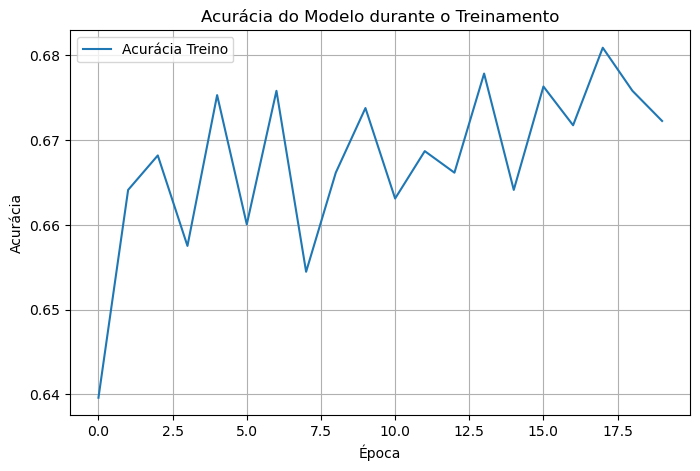

In [70]:
# --- 9. Gráfico de acurácia do modelo ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Acurácia Treino')

plt.title('Acurácia do Modelo durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

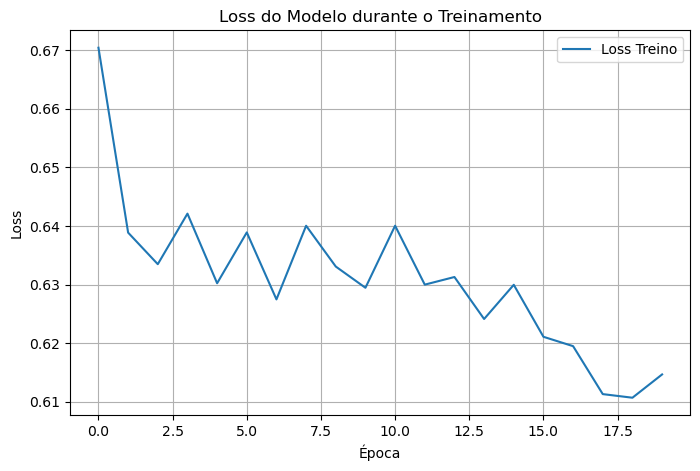

In [71]:
# --- 10. Gráfico de loss do modelo ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Loss Treino')
plt.title('Loss do Modelo durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Fine Tune

In [21]:
import os
import numpy as np
import cv2
import pandas as pd
import json
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [13]:
MODELO_SALVO_ORIGINAL = os.path.join(CAMINHO_BASE, 'models', 'gaze_attention_model.keras')
MODELO_SALVO_FINETUNED = os.path.join(CAMINHO_BASE, 'models', 'gaze_attention_model_finetuned.keras')

In [14]:
model = load_model(MODELO_SALVO_ORIGINAL)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,742,085 (37.16 MB)

 Trainable params: 3,247,361 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,494,724 (24.78 MB)

In [15]:
PATH_MPIIGAZE_DATA = os.path.join(MPIIGAZE_PATH, 'Data')
PATH_DATA_NORMALIZED = os.path.join(PATH_MPIIGAZE_DATA, 'Normalized')

In [55]:
IMG_SIZE = (64, 64) # O tamanho da imagem deve ser o mesmo do modelo original
TIME_WINDOW = 10 # O tamanho da janela de tempo deve ser o mesmo
BATCH_SIZE = 32

# É uma estimativa. Você pode precisar ajustar para o seu dataset.
# Uma estimativa segura pode ser obtida inspecionando um arquivo .mat e contando as amostras.
SAMPLES_PER_MAT_FILE_ESTIMATED = 2000

# --- NOVO: Define o número de arquivos .mat que você quer usar ---
NUM_FILES_TO_USE = 200# Exemplo: usará 100 dos 521 arquivos disponíveis. Ajuste este valor.
# --- FIM DO NOVO ---


In [56]:
all_images_mpii = []
all_labels_mpii = []

In [57]:
import random

In [58]:
mat_file_paths = []
for participant_dir in sorted(os.listdir(PATH_DATA_NORMALIZED)):
    participant_path = os.path.join(PATH_DATA_NORMALIZED, participant_dir)
    if os.path.isdir(participant_path):
        for day_file in sorted(os.listdir(participant_path)):
            if day_file.endswith('.mat'):
                mat_file_paths.append(os.path.join(participant_path, day_file))

# Embaralha e seleciona uma amostra do número total de arquivos
if len(mat_file_paths) > NUM_FILES_TO_USE:
    # random.sample é ideal para selecionar uma amostra aleatória sem repetição
    mat_file_paths = random.sample(mat_file_paths, NUM_FILES_TO_USE)


print(f"Total de arquivos .mat encontrados (após amostragem): {len(mat_file_paths)}")

# Dividir os caminhos dos arquivos para treino e validação
train_paths, val_paths = train_test_split(mat_file_paths, test_size=0.2, random_state=42)

print(f"Arquivos para treino: {len(train_paths)}, para validação: {len(val_paths)}")

Total de arquivos .mat encontrados (após amostragem): 200
Arquivos para treino: 160, para validação: 40


In [59]:
for participant_dir in sorted(os.listdir(PATH_DATA_NORMALIZED)):
    participant_path = os.path.join(PATH_DATA_NORMALIZED, participant_dir)
    if os.path.isdir(participant_path):
        print(f"Processando dados do participante: {participant_dir}")
        for day_file in sorted(os.listdir(participant_path)):
            if day_file.endswith('.mat'):
                day_path = os.path.join(participant_path, day_file)
                try:
                    mat_data = loadmat(day_path)
                    
                    # Acessa a estrutura aninhada, que sabemos que existe
                    content = mat_data['data'][0, 0]
                    
                    # --- CÓDIGO CRUCIAL: Imprime os nomes dos campos dentro de `content` ---
                    print(f"Nomes dos campos no arquivo {day_file}:")
                    print(content.dtype.names)
                    # Use um break para parar após inspecionar o primeiro arquivo
                    # para que não tenhamos uma saída muito longa
                    break
                except Exception as e:
                    print(f"Erro ao processar o arquivo {day_path}: {e}")
        if 'content' in locals():
            break # Pare o loop externo após o primeiro arquivo ser inspecionado

print("--------------------------------------------------")
print("Análise inicial concluída. Por favor, me forneça a saída acima.")
print("Com base nos nomes dos campos, ajustaremos o código de carregamento.")
print("--------------------------------------------------")

Processando dados do participante: p00
Nomes dos campos no arquivo day01.mat:
('right', 'left')
--------------------------------------------------
Análise inicial concluída. Por favor, me forneça a saída acima.
Com base nos nomes dos campos, ajustaremos o código de carregamento.
--------------------------------------------------


In [60]:
def data_generator_regression(file_paths, img_size, time_window):
    """
    Gerador que lê arquivos .mat e produz sequências de imagens e rótulos contínuos (pitch e yaw).
    """
    for mat_file_path in file_paths:
        try:
            mat_data = loadmat(mat_file_path)
            content = mat_data['data'][0, 0]
            
            all_images_file = []
            all_labels_file = []
            
            for eye_key in ['left', 'right']:
                eye_data = content[eye_key][0, 0]
                images_raw = eye_data['image']
                gaze_labels_raw = eye_data['gaze']

                for img_raw, label_raw in zip(images_raw, gaze_labels_raw):
                    img_resized = cv2.resize(img_raw, img_size)
                    if len(img_resized.shape) == 2:
                        img_resized = np.expand_dims(img_resized, axis=-1)
                        img_resized = np.repeat(img_resized, 3, axis=-1)
                    img_normalized = img_resized.astype('float32') / 255.0
                    all_images_file.append(img_normalized)

                    # Rótulo contínuo: vetor de 2 elementos (pitch, yaw)
                    label_continuous = np.array([label_raw[0], label_raw[1]], dtype=np.float32)
                    all_labels_file.append(label_continuous)
            
            # Agrupa em sequências
            for i in range(len(all_images_file) - time_window + 1):
                sequence = np.array(all_images_file[i:i + time_window])
                # Para regressão, o rótulo da sequência pode ser o rótulo do último frame
                # ou a média. Vamos usar o último rótulo para simplificar.
                sequence_label = np.array(all_labels_file[i + time_window - 1])
                yield sequence, sequence_label
        
        except Exception as e:
            print(f"Erro no gerador ao processar o arquivo {mat_file_path}: {e}")
            continue

In [61]:
# Definindo as especificações da saída do gerador para regressão (pitch, yaw)
output_signature = (
    tf.TensorSpec(shape=(TIME_WINDOW, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(2,), dtype=tf.float32) # Rótulo agora é um vetor de 2 elementos
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_regression(train_paths, IMG_SIZE, TIME_WINDOW),
    output_signature=output_signature
).shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_regression(val_paths, IMG_SIZE, TIME_WINDOW),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
# Carrega o modelo pré-treinado
modelo_base = load_model(MODELO_SALVO_ORIGINAL)

# Cria um novo modelo com as camadas do modelo original, mas com a última camada modificada.
new_model = Sequential()
for layer in modelo_base.layers[:-1]: # Exclui a última camada
    new_model.add(layer)

# Adiciona uma nova camada de saída para regressão (2 neurônios para pitch e yaw)
new_model.add(Dense(2, activation='linear'))

# Congela as camadas convolucionais
for layer in new_model.layers[:-2]:
    layer.trainable = False

# Recompila o modelo para a tarefa de regressão
new_model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error']) # Métrica comum para regressão

new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,247,296 (12.39 MB)

 Trainable params: 3,227,904 (12.31 MB)

 Non-trainable params: 19,392 (75.75 KB)

In [64]:
print("\nIniciando o fine-tuning do modelo com o dataset MPIIGaze para regressão...")

history_finetune = new_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

print("Fine-tuning concluído!")

# Salve o modelo
new_model.save('..\\models\\gaze_attention_model_finetuned_regression.keras')
print("Modelo ajustado salvo.")


Iniciando o fine-tuning do modelo com o dataset MPIIGaze para regressão...
Epoch 1/10
3819/3819 ━━━━━━━━━━━━━━━━━━━━ 537s 140ms/step - loss: 0.1202 - mean_absolute_error: 0.1519 - val_loss: 0.0099 - val_mean_absolute_error: 0.0796
Epoch 2/10
3819/3819 ━━━━━━━━━━━━━━━━━━━━ 535s 140ms/step - loss: 0.0086 - mean_absolute_error: 0.0733 - val_loss: 0.0090 - val_mean_absolute_error: 0.0753
Epoch 3/10
3819/3819 ━━━━━━━━━━━━━━━━━━━━ 568s 149ms/step - loss: 0.0078 - mean_absolute_error: 0.0690 - val_loss: 0.0086 - val_mean_absolute_error: 0.0733
Epoch 4/10
3819/3819 ━━━━━━━━━━━━━━━━━━━━ 550s 144ms/step - loss: 0.0075 - mean_absolute_error: 0.0670 - val_loss: 0.0083 - val_mean_absolute_error: 0.0718
Epoch 5/10
3819/3819 ━━━━━━━━━━━━━━━━━━━━ 535s 140ms/step - loss: 0.0071 - mean_absolute_error: 0.0654 - val_loss: 0.0081 - val_mean_absolute_error: 0.0705
Epoch 6/10
3819/3819 ━━━━━━━━━━━━━━━━━━━━ 537s 141ms/step - loss: 0.0069 - mean_absolute_error: 0.0639 - val_loss: 0.0078 - val_mean_absolute_er

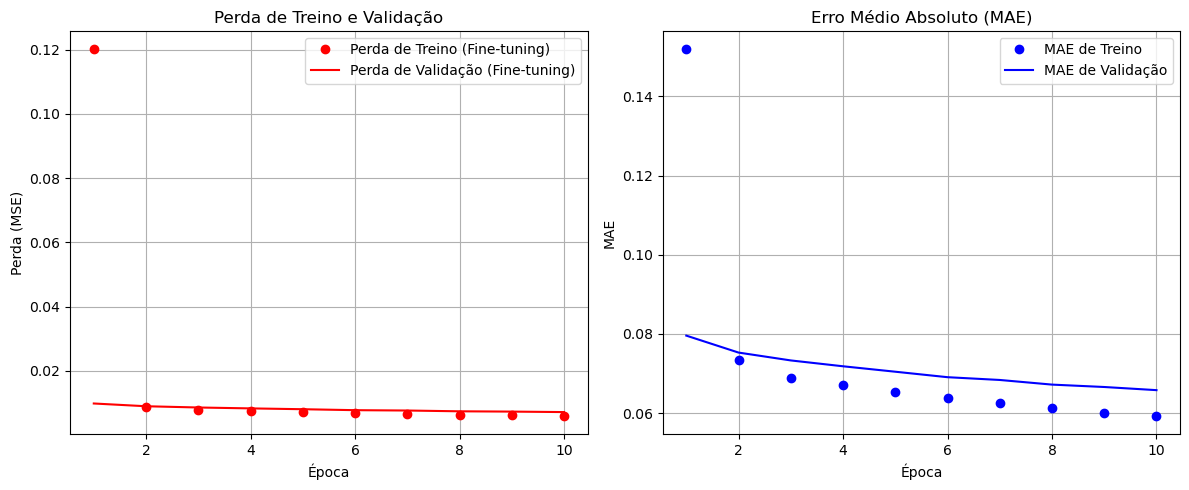

In [65]:
# Salve o histórico de treinamento em um arquivo JSON
with open('training_history_finetune_regression.json', 'w') as f:
    json.dump(history_finetune.history, f)

# Carregue o histórico de treinamento
with open('training_history_finetune_regression.json', 'r') as f:
    history = json.load(f)

# Obtenha os dados de perda e MAE
loss = history['loss']
val_loss = history['val_loss']
mae = history['mean_absolute_error']
val_mae = history['val_mean_absolute_error']
epochs = range(1, len(loss) + 1)

# Crie os subplots para os gráficos
plt.figure(figsize=(12, 5))

# Gráfico para a Perda (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'ro', label='Perda de Treino (Fine-tuning)')
plt.plot(epochs, val_loss, 'r', label='Perda de Validação (Fine-tuning)')
plt.title('Perda de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.grid(True)

# Gráfico para o Erro Médio Absoluto (MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo', label='MAE de Treino')
plt.plot(epochs, val_mae, 'b', label='MAE de Validação')
plt.title('Erro Médio Absoluto (MAE)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()